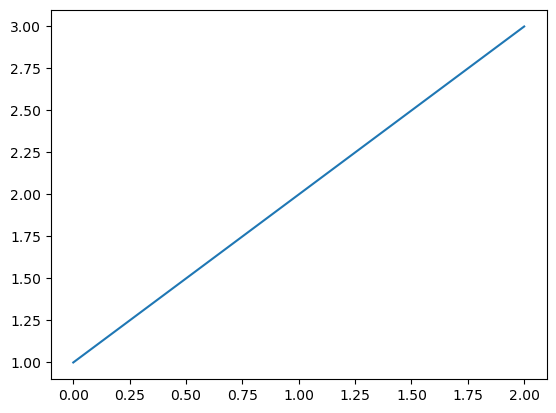

In [ ]:
import matplotlib.pyplot as plt

plt.plot([1,2,3])

In [2]:
import torch
from torch.utils.data import Dataset
from pathlib import Path
import os
from torchvision import io
import pickle
import sys
import numpy as np

Dataloader

In [3]:
class BaseHISDataset(Dataset):
    def __init__(self, 
                 images_dir: str,
                 annotations_dir: str):
        """Base loader for hierarchical dataset

        Args:
            images_dir (str): path to source images folder
            annotations_dir (str): path to annotation tree folder            
        """
        super().__init__()
        self.images_dir = images_dir
        self.annotations_dir = annotations_dir
        self.images = os.listdir(images_dir)
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        # read image
        image = io.read_image(str(Path(self.images_dir) / self.images[index])).float()
        image /= 255
        
        
        # read annotations
        with open(str(Path(self.annotations_dir) /
                  self.images[index].replace(".png", ".pkl")), "rb") as f:
            annotation = pickle.load(f)
            

        return image, annotation

In [4]:
def generateAnnotationMask(annotation: tuple, attentionMask: np.ndarray, threshold: float=0.1) -> np.ndarray:
    
    attentionMaskSum = np.sum(attentionMask)
    annotationMask = np.zeros_like(attentionMask)
    
    def _inorder(ann):
        mask = attentionMask & ann[1]
        intersection = np.sum(mask)
        if (attentionMaskSum-intersection)/attentionMaskSum > threshold:
            nonlocal annotationMask
            annotationMask = annotationMask | mask
            return
        
        for child in ann[2]:
            _inorder(child)
            
    _inorder(annotation)
    
    return annotationMask

Model definition

In [5]:
from torch import nn

In [54]:
class ModelSeg1(nn.Module):
    def __init__(self):
        super().__init__()
        self.down = nn.Sequential(
            nn.Conv2d(4, 32, 3, 1, 1),
            nn.MaxPool2d(2, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, 3, 1, 1),
            nn.MaxPool2d(2, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, 3, 1, 1),
            nn.MaxPool2d(2, 1),
            nn.ReLU(inplace=True),
        )
        
        self.up = nn.Sequential(
            nn.ConvTranspose2d(128, 128, 2, 1),
            nn.Conv2d(128, 64, 3, 1, 1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 64, 2, 1),
            nn.Conv2d(64, 32, 3, 1, 1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 32, 2, 1),
            nn.Conv2d(32, 32, 3, 1, 1),
            nn.Conv2d(32, 1, 3, 1, 1),
        )
    
    def forward(self, x):
        x = self.down(x)
        x = self.up(x)
        
        return x

In [6]:
import torchvision.transforms.functional as TF

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False), # no bias for batch norm
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, x):
        return self.conv(x)
    
class UNet(nn.Module):
    def __init__(
        self,
        in_channels=4, 
        out_channels=1,
        features=[64, 128, 256, 512],
        dropout=0.,
    ):
        super().__init__()
        
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = dropout
        
        # downs
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature
            
        # ups
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2,
                    feature,
                    2,
                    2
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))
            
        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        
        self.final_conv = nn.Conv2d(features[0], out_channels, 1)
    
    def forward(self, x):
        skip_connections = []
        
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)
            x = nn.functional.dropout2d(x, self.dropout)
            
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]
        
        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]
            
            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:], antialias=True)
            
            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)
            x = nn.functional.dropout2d(x, self.dropout)
            
        return self.final_conv(x)
    
    def grad_norm(self):
        total_norm = 0.0
        for param in self.parameters():
            if param.grad is not None:
                param_norm = param.grad.data.norm(2)
                total_norm += param_norm.item() ** 2

        return total_norm

In [7]:
# test input
UNet()(torch.rand((8, 4, 200, 200))).shape

torch.Size([8, 1, 200, 200])

Data split

In [7]:
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter

In [71]:
dataset = BaseHISDataset("../data/dataset_3_200/data/", "../data/dataset_3_200/treeAnnotations/")

In [9]:
len(dataset)

50

In [73]:
train_dataset, val_dataset = random_split(
    dataset, [175, 25], torch.Generator().manual_seed(10)
)

In [24]:
# can't batch unequal outputs
# train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
# val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)

Training loop

In [11]:
import random

In [12]:
def genAttentionMask(size):
    x, y = size
    ret = np.zeros(size)
    x1, y1 = random.randint(0, x//4-1), random.randint(0, y//4-1)
    w, h = random.randint(y1+10, y-1), random.randint(x1+10, x-1)
    
    ret[x1:h, y1:w] = 1
    
    if random.random() > 0.5:
        ret = ret.T
    return ret

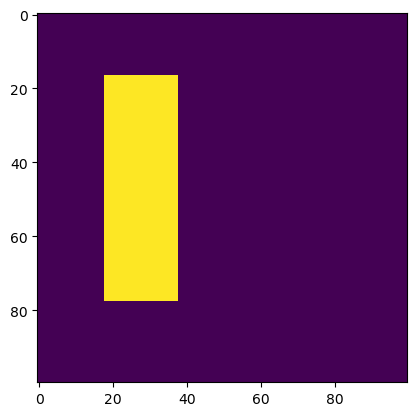

In [13]:
plt.imshow(genAttentionMask((100, 100)))

In [13]:
from torchvision.transforms import v2
from torchvision import tv_tensors

In [32]:
transforms = v2.Compose([
    v2.RandomHorizontalFlip(),
    v2.RandomVerticalFlip(),
    # v2.RandomResizedCrop((200, 200)),
    # v2.ColorJitter(0.1)
    v2.RandomRotation(10)
])

In [18]:
class ShapeAwareBinarySegmentationLoss(nn.Module):
    def __init__(self, weight=None, size_average=None, reduce=None, reduction='mean', shape_lambda=0.1):
        super(ShapeAwareBinarySegmentationLoss, self).__init__()
        self.bce_loss = nn.BCELoss(weight, size_average, reduce, reduction)
        self.shape_lambda = shape_lambda

    def forward(self, input, target):
        bce_loss = self.bce_loss(input, target)

        # Compute shape regularization term here
        shape_reg_loss = self.shape_regularization(input, target)

        # Combine losses
        loss = bce_loss + self.shape_lambda * shape_reg_loss

        return loss

    def shape_regularization(self, input, target):
        # Example shape regularization: encouraging smoothness of the contour
        # You can replace this with any other shape constraint method
        
        # Compute the gradient of the predicted mask
        gradient_x = torch.abs(input[ :, :, :-1] - input[ :, :, 1:])
        gradient_y = torch.abs(input[ :, :-1, :] - input[ :, 1:, :])
        gradient = torch.mean(gradient_x) + torch.mean(gradient_y)

        return gradient

In [74]:
model = UNet().to("cuda")
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
loss = torch.nn.BCEWithLogitsLoss()
loss2 = lambda x, y: torch.nn.L1Loss()(x.sigmoid(), y)
# loss = ShapeAwareBinarySegmentationLoss()

In [75]:
writer = SummaryWriter(f"./runs/UNet/r1_200", comment="Baseline, contrived dataset, scaling, no random cuts, no scale aug")

In [91]:
writer.close()

In [77]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)

In [82]:
for e in range(60, 100):
    
    epoch_loss = 0
    
    for data in train_dataset:
        image, annotation = data
        attention_mask = annotation[1]
        for i in range(5):
            annotation_mask = torch.tensor(
                generateAnnotationMask(annotation, attention_mask)
                ).unsqueeze(dim=0).float().to("cuda")
            
            
            image, o = transforms(image.float(), {
                "annotation_mask":tv_tensors.Mask(annotation_mask.float()),
                "attention_mask":tv_tensors.Mask(torch.tensor(attention_mask).float())
                })
            
            # model input
            image_cat = torch.cat([image, torch.tensor(o["attention_mask"]).unsqueeze(dim=0)], dim=0).to("cuda")
            
            # zero gradients
            optimizer.zero_grad()
                        
            # forward pass
            output = model(image_cat.unsqueeze(dim=0))
            
            # loss
            # if i%2:
            l = loss(output.squeeze(dim=0), o["annotation_mask"])
            # else:
            #     l = loss2(output.squeeze(dim=0), annotation_mask)
            
            l.backward()
            
            optimizer.step()
            # if i%2:
            epoch_loss += float(l)
            print(f"Loss: {float(l)}", end="\r")
            
            # smaller attention
            # attention_mask = annotation[2][0][1]
            attention_mask = genAttentionMask((200, 200)) == 1
            
    writer.add_scalar("Loss/train", epoch_loss, e)
    print(f"\nEpoch {e}: {epoch_loss}")

/tmp/ipykernel_1553/965652618.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image_cat = torch.cat([image, torch.tensor(o["attention_mask"]).unsqueeze(dim=0)], dim=0).to("cuda")


Loss: 0.0564455799758434383
Epoch 60: 50.13133672566619
Loss: 0.0343487970530986814
Epoch 61: 49.24273225013167
Loss: 0.0594624392688274425
Epoch 62: 47.269668765948154
Loss: 0.0961533933877945806
Epoch 63: 46.23306106450036
Loss: 0.0273181088268756874
Epoch 64: 47.200352965970524
Loss: 0.0072900252416729933
Epoch 65: 46.14676115184557
Loss: 0.0150741925463080497
Epoch 66: 46.43324157316238
Loss: 0.0872741192579269455
Epoch 67: 44.79425792070106
Loss: 0.1034846380352974386
Epoch 68: 44.17469522065949
Loss: 0.0031107619870454073
Epoch 69: 45.20426333730575
Loss: 0.0116538414731621748
Epoch 70: 45.34439828165341
Loss: 0.0076842154376208783
Epoch 71: 44.81400285568088
Loss: 0.0059338589198887355
Epoch 72: 45.60115640424192
Loss: 0.0762737542390823425
Epoch 73: 49.89087066455977
Loss: 0.0465314500033855447
Epoch 74: 44.89417468610918
Loss: 0.0025152969174087048
Epoch 75: 43.63525976939127
Loss: 0.0121871735900640496
Epoch 76: 43.39276922121644
Loss: 0.1760148108005523738
Epoch 77: 47.00619

torch.Size([4, 200, 200]) torch.Size([1, 200, 200])
torch.Size([4, 200, 200]) torch.Size([1, 200, 200])
torch.Size([4, 200, 200]) torch.Size([1, 200, 200])


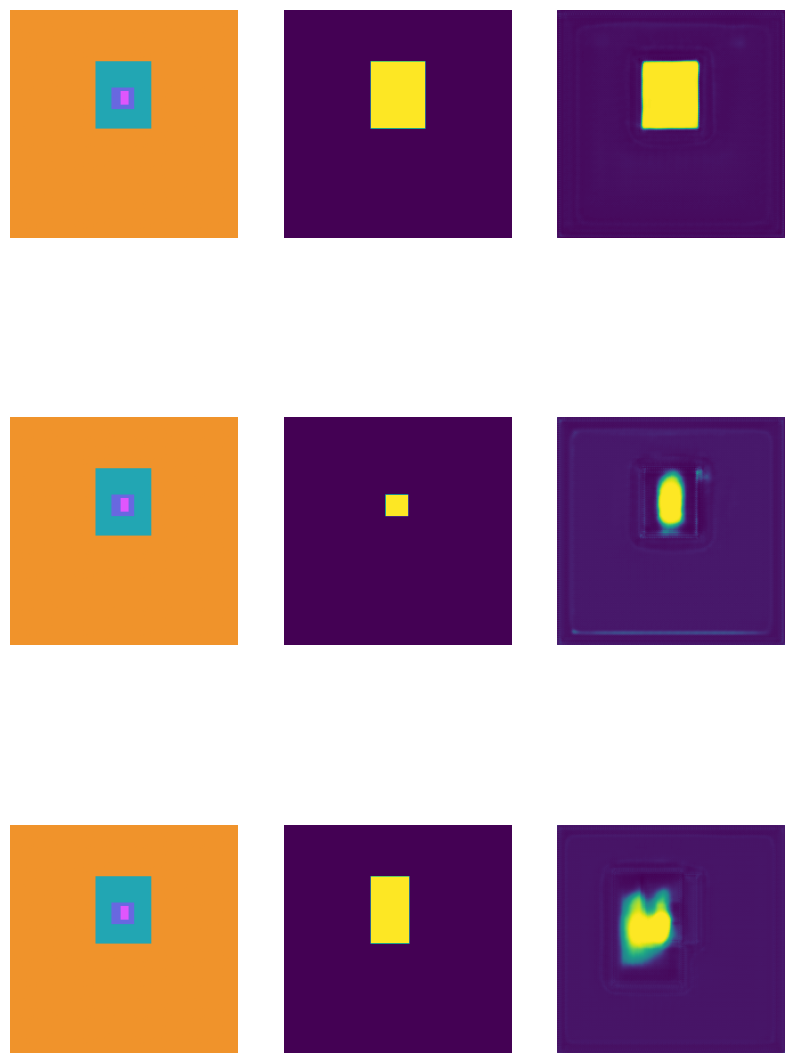

In [40]:
# model.eval()
with torch.inference_mode():
    image, annotation = val_dataset[2]
    attention_mask = annotation[1]
    # attention_mask = output.squeeze().sigmoid().numpy() > 0.2
    annotation_mask = torch.tensor(
                generateAnnotationMask(annotation, attention_mask)
                ).unsqueeze(dim=0).float()
    
    image_cat = torch.cat([image, torch.tensor(attention_mask).unsqueeze(dim=0)], dim=0).to("cuda")
    
    print(image_cat.shape, annotation_mask.shape)
    
    output = model(image_cat.unsqueeze(dim=0))
    
    plt.figure(figsize=(10, 15))
    plt.subplot(3, 3, 1)
    plt.imshow(image.cpu().permute(1,2,0))
    plt.axis("off")
    
    plt.subplot(3, 3, 2)
    plt.imshow(annotation_mask.squeeze())
    plt.axis("off")
    
    plt.subplot(3, 3, 3)
    plt.imshow(output.cpu().squeeze().sigmoid())
    plt.axis("off")
    
    attention_mask = annotation[2][0][1]
    image_cat = torch.cat([image, torch.tensor(attention_mask).unsqueeze(dim=0)], dim=0).to("cuda")
    annotation_mask = torch.tensor(
                generateAnnotationMask(annotation, attention_mask)
                ).unsqueeze(dim=0).float()
    
    print(image_cat.shape, annotation_mask.shape)
    
    output = model(image_cat.unsqueeze(dim=0))
    plt.subplot(3, 3, 4)
    plt.imshow(image.cpu().permute(1,2,0))
    plt.axis("off")
    
    plt.subplot(3, 3, 5)
    plt.imshow(annotation_mask.squeeze())
    plt.axis("off")
    
    plt.subplot(3, 3, 6)
    plt.imshow(output.cpu().squeeze().sigmoid())
    plt.axis("off")
    
    attention_mask = np.zeros((200, 200))
    attention_mask[40: 140, 50: 110] = 1
    attention_mask = attention_mask == 1
    image_cat = torch.cat([image, torch.tensor(attention_mask).unsqueeze(dim=0)], dim=0).to("cuda")
    annotation_mask = torch.tensor(
                generateAnnotationMask(annotation, attention_mask)
                ).unsqueeze(dim=0).float()
    print(image_cat.shape, annotation_mask.shape)
    
    output = model(image_cat.unsqueeze(dim=0))
    plt.subplot(3, 3, 7)
    plt.imshow(image.cpu().permute(1,2,0))
    plt.axis("off")
    
    plt.subplot(3, 3, 8)
    plt.imshow(annotation_mask.squeeze())
    plt.axis("off")
    
    plt.subplot(3, 3, 9)
    plt.imshow(output.squeeze().cpu().sigmoid())
    plt.axis("off")

- The loss function is not really good as the images seem to get worse although the loss decreases, needs more training to converge

- The augmentation strategy seems to be mapping attention mask to annotation mask in many cases, leading to bad training examples

- the model is not able to overfit the training data

- it is not learning the nested representations well, could it be the fixed type of calculations in the convnet for each type of detection distribution. Here we want to learn multiple distributions in same model "objectness" rather than "carness" or "plantness" which has much high variability

torch.Size([4, 200, 200]) torch.Size([1, 200, 200])
torch.Size([4, 200, 200]) torch.Size([1, 200, 200])
torch.Size([4, 200, 200]) torch.Size([1, 200, 200])


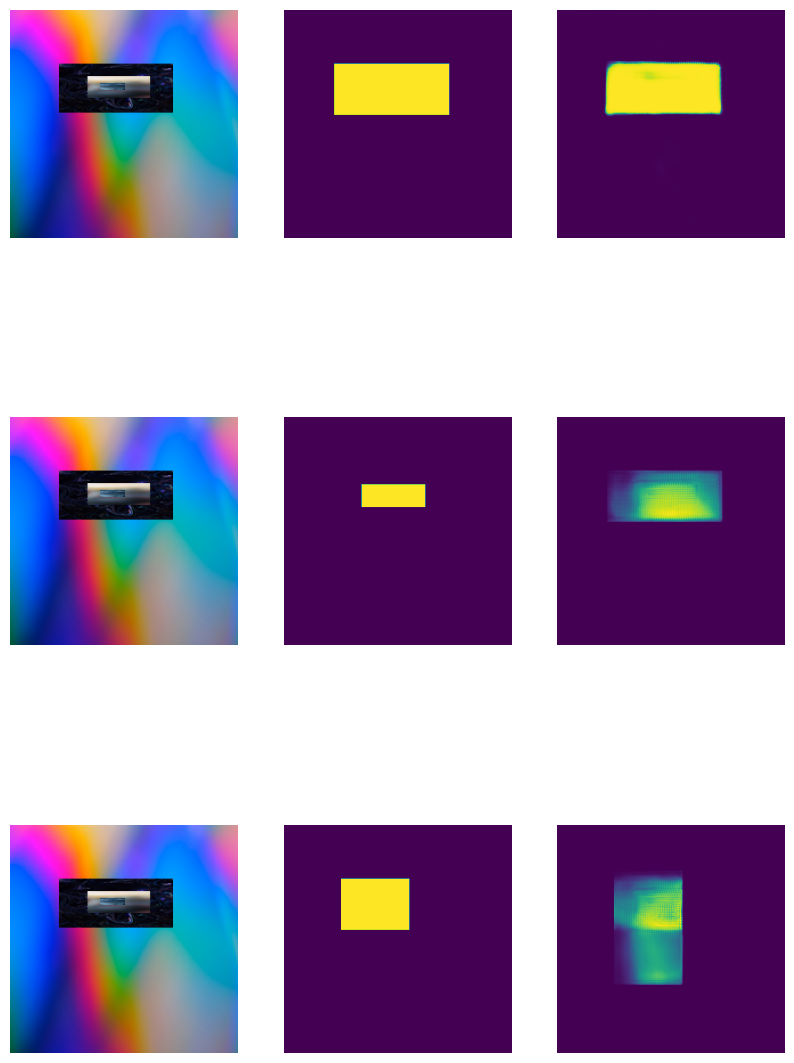

In [81]:
# model.eval()
with torch.inference_mode():
    image, annotation = val_dataset[19]
    attention_mask = annotation[1]
    # attention_mask = output.squeeze().sigmoid().numpy() > 0.2
    annotation_mask = torch.tensor(
                generateAnnotationMask(annotation, attention_mask)
                ).unsqueeze(dim=0).float()
    
    image_cat = torch.cat([image, torch.tensor(attention_mask).unsqueeze(dim=0)], dim=0).to("cuda")
    
    print(image_cat.shape, annotation_mask.shape)
    
    output = model(image_cat.unsqueeze(dim=0))
    
    plt.figure(figsize=(10, 15))
    plt.subplot(3, 3, 1)
    plt.imshow(image.cpu().permute(1,2,0))
    plt.axis("off")
    
    plt.subplot(3, 3, 2)
    plt.imshow(annotation_mask.squeeze())
    plt.axis("off")
    
    plt.subplot(3, 3, 3)
    plt.imshow(output.cpu().squeeze().sigmoid())
    plt.axis("off")
    
    attention_mask = annotation[2][0][1]
    image_cat = torch.cat([image, torch.tensor(attention_mask).unsqueeze(dim=0)], dim=0).to("cuda")
    annotation_mask = torch.tensor(
                generateAnnotationMask(annotation, attention_mask)
                ).unsqueeze(dim=0).float()
    
    print(image_cat.shape, annotation_mask.shape)
    
    output = model(image_cat.unsqueeze(dim=0))
    plt.subplot(3, 3, 4)
    plt.imshow(image.cpu().permute(1,2,0))
    plt.axis("off")
    
    plt.subplot(3, 3, 5)
    plt.imshow(annotation_mask.squeeze())
    plt.axis("off")
    
    plt.subplot(3, 3, 6)
    plt.imshow(output.cpu().squeeze().sigmoid())
    plt.axis("off")
    
    attention_mask = np.zeros((200, 200))
    attention_mask[40: 140, 50: 110] = 1
    attention_mask = attention_mask == 1
    image_cat = torch.cat([image, torch.tensor(attention_mask).unsqueeze(dim=0)], dim=0).to("cuda")
    annotation_mask = torch.tensor(
                generateAnnotationMask(annotation, attention_mask)
                ).unsqueeze(dim=0).float()
    print(image_cat.shape, annotation_mask.shape)
    
    output = model(image_cat.unsqueeze(dim=0))
    plt.subplot(3, 3, 7)
    plt.imshow(image.cpu().permute(1,2,0))
    plt.axis("off")
    
    plt.subplot(3, 3, 8)
    plt.imshow(annotation_mask.squeeze())
    plt.axis("off")
    
    plt.subplot(3, 3, 9)
    plt.imshow(output.squeeze().cpu().sigmoid())
    plt.axis("off")

⭐ With correct masks the method seems to be doing reasonably well, as it can atleast overfit the training data

# Weighted border loss

In [42]:
from scipy.signal import convolve2d
import cv2

def genEuclidianDistMatrix(height, width):
    c_x, c_y = height//2, width//2
    
    res = np.zeros((height, width))
    
    for i in range(height):
        for j in range(width):
            res[i, j] = (c_x-i)**2 + (c_y-j)**2
    
    return res
genEuclidianDistMatrix(7, 7)

array([[18., 13., 10.,  9., 10., 13., 18.],
       [13.,  8.,  5.,  4.,  5.,  8., 13.],
       [10.,  5.,  2.,  1.,  2.,  5., 10.],
       [ 9.,  4.,  1.,  0.,  1.,  4.,  9.],
       [10.,  5.,  2.,  1.,  2.,  5., 10.],
       [13.,  8.,  5.,  4.,  5.,  8., 13.],
       [18., 13., 10.,  9., 10., 13., 18.]])

In [43]:
def getWeightedLoss(map, device="cuda"):
    border = map - cv2.erode(map.astype(np.uint8), np.ones((3,3)))
    border_w = convolve2d(
                border,
                np.exp(-genEuclidianDistMatrix(10, 10)),
                mode="same") + 1
    
    border = border_w + map*2
    
    return torch.nn.BCEWithLogitsLoss(weight=torch.tensor(border_w).to(device))
    

In [44]:
model = UNet(features=[64, 128, 256, 512]).to("cuda")
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
writer = SummaryWriter(f"./runs/d2/UNet/Borderloss", comment="Baseline, contrived dataset, border weighted")

In [33]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-6)

In [45]:
for e in range(20):
    
    epoch_loss = 0
    
    for data in train_dataset:
        image, annotation = data
        attention_mask = annotation[1]
        for i in range(20):
            annotation_mask = torch.tensor(
                generateAnnotationMask(annotation, attention_mask)
                ).unsqueeze(dim=0).float().to("cuda")
            
            
            image, o = transforms(image.float(), {
                "annotation_mask":tv_tensors.Mask(annotation_mask.float()),
                "attention_mask":tv_tensors.Mask(torch.tensor(attention_mask).float())
                })
            
            # model input
            image_cat = torch.cat([image, torch.tensor(o["attention_mask"]).unsqueeze(dim=0)], dim=0).to("cuda")
            
            # zero gradients
            optimizer.zero_grad()
                        
            # forward pass
            output = model(image_cat.unsqueeze(dim=0))
            
            # loss
            # if i%2:
            loss = getWeightedLoss(o["annotation_mask"].squeeze().cpu().numpy())
            
            l = loss(output.squeeze(dim=0), o["annotation_mask"])
            # else:
                # l = loss2(output.squeeze(dim=0), annotation_mask)
            
            l.backward()
            
            optimizer.step()
            # if i%2:
            epoch_loss += float(l)
            print(f"Loss: {float(l)}", end="\r")
            
            # smaller attention
            # attention_mask = output.squeeze().detach().numpy() > 0.3
            attention_mask = genAttentionMask((200, 200)) == 1
            
    writer.add_scalar("Loss/train", epoch_loss, e)
    print(f"\nEpoch {e}: {epoch_loss}")
    


/home/ankush/miniconda3/envs/vit/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/tmp/ipykernel_32540/2238919617.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image_cat = torch.cat([ima

Loss: 0.38045996427536013
Epoch 0: 412.32038432359695
Loss: 0.34888422489166264
Epoch 1: 342.46810092031956
Loss: 0.28313606977462777
Epoch 2: 305.90475660562515
Loss: 0.26711025834083557
Epoch 3: 283.5703561306
Loss: 0.15091535449028015
Epoch 4: 278.3566496372223
Loss: 0.24291653931140958
Epoch 5: 265.74698355793953
Loss: 0.21456748247146606
Epoch 6: 247.71423011273146
Loss: 0.15415242314338684
Epoch 7: 234.36482620984316
Loss: 0.10374397039413452
Epoch 8: 226.41141548752785
Loss: 0.92140829563140872
Epoch 9: 226.8602690398693
Loss: 0.07530435919761658
Epoch 10: 226.9973204433918
Loss: 0.396357864141464234
Epoch 11: 207.22058883681893
Loss: 0.338161259889602665
Epoch 12: 219.68268305435777
Loss: 0.122080132365226756
Epoch 13: 209.0319235511124
Loss: 0.253992021083831854
Epoch 14: 200.60385730490088
Loss: 0.108704246580600745
Epoch 15: 204.01603254303336
Loss: 0.034923207014799126
Epoch 16: 209.01531898975372
Loss: 0.150068044662475595
Epoch 17: 204.9611904732883
Loss: 0.32697468996047

torch.Size([4, 200, 200]) torch.Size([1, 200, 200])
torch.Size([4, 200, 200]) torch.Size([1, 200, 200])
torch.Size([4, 200, 200]) torch.Size([1, 200, 200])


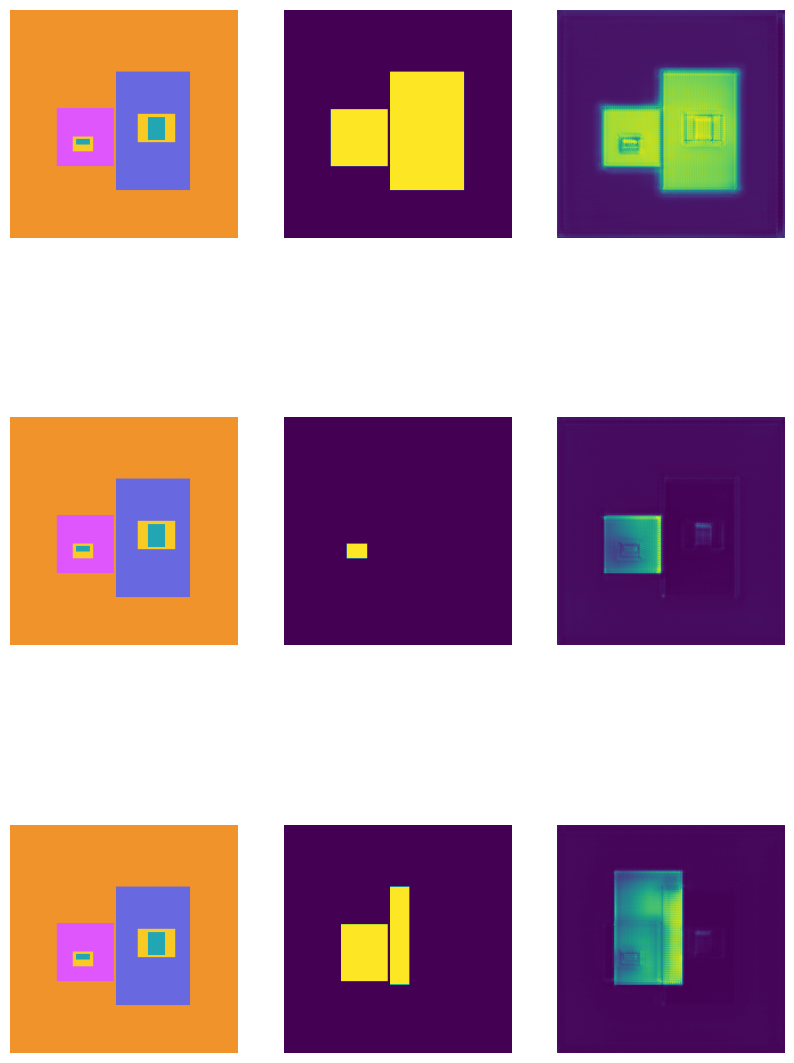

In [46]:
# model.eval()
with torch.inference_mode():
    image, annotation = val_dataset[1]
    attention_mask = annotation[1]
    # attention_mask = output.squeeze().sigmoid().numpy() > 0.2
    annotation_mask = torch.tensor(
                generateAnnotationMask(annotation, attention_mask)
                ).unsqueeze(dim=0).float()
    
    image_cat = torch.cat([image, torch.tensor(attention_mask).unsqueeze(dim=0)], dim=0).to("cuda")
    
    print(image_cat.shape, annotation_mask.shape)
    
    output = model(image_cat.unsqueeze(dim=0))
    
    plt.figure(figsize=(10, 15))
    plt.subplot(3, 3, 1)
    plt.imshow(image.cpu().permute(1,2,0))
    plt.axis("off")
    
    plt.subplot(3, 3, 2)
    plt.imshow(annotation_mask.squeeze())
    plt.axis("off")
    
    plt.subplot(3, 3, 3)
    plt.imshow(output.cpu().squeeze().sigmoid())
    plt.axis("off")
    
    attention_mask = annotation[2][0][1]
    image_cat = torch.cat([image, torch.tensor(attention_mask).unsqueeze(dim=0)], dim=0).to("cuda")
    annotation_mask = torch.tensor(
                generateAnnotationMask(annotation, attention_mask)
                ).unsqueeze(dim=0).float()
    
    print(image_cat.shape, annotation_mask.shape)
    
    output = model(image_cat.unsqueeze(dim=0))
    plt.subplot(3, 3, 4)
    plt.imshow(image.cpu().permute(1,2,0))
    plt.axis("off")
    
    plt.subplot(3, 3, 5)
    plt.imshow(annotation_mask.squeeze())
    plt.axis("off")
    
    plt.subplot(3, 3, 6)
    plt.imshow(output.cpu().squeeze().sigmoid())
    plt.axis("off")
    
    attention_mask = np.zeros((200, 200))
    attention_mask[40: 140, 50: 110] = 1
    attention_mask = attention_mask == 1
    image_cat = torch.cat([image, torch.tensor(attention_mask).unsqueeze(dim=0)], dim=0).to("cuda")
    annotation_mask = torch.tensor(
                generateAnnotationMask(annotation, attention_mask)
                ).unsqueeze(dim=0).float()
    print(image_cat.shape, annotation_mask.shape)
    
    output = model(image_cat.unsqueeze(dim=0))
    plt.subplot(3, 3, 7)
    plt.imshow(image.cpu().permute(1,2,0))
    plt.axis("off")
    
    plt.subplot(3, 3, 8)
    plt.imshow(annotation_mask.squeeze())
    plt.axis("off")
    
    plt.subplot(3, 3, 9)
    plt.imshow(output.squeeze().cpu().sigmoid())
    plt.axis("off")

In [56]:
c = 0
for p in model.parameters():
    c += p.numel()
    
print(f"{c:_}")

31_038_209


Rather than augmenting the channel with attention mask, use it as prompt, like in SAM

# Vision Transformer

In [34]:
class PatchEmbedding_raw(nn.Module):
    """
    Breaks down raw image to linear layers
    """
    def __init__(self, in_channels, patch_size, num_patches):
        super().__init__()
        self.patch_size = patch_size
        self.num_patches = num_patches
        self.in_channels = in_channels
        
        # learnable position embeddings
        self.position_embeddings = nn.Parameter(torch.randn((1, num_patches, in_channels*patch_size**2)), requires_grad=True)
        
    def forward(self, x):
        b, c, _, _ = x.shape
        x = (x
             .permute(0, 2, 3, 1)
             .flatten(1)
             .reshape(b, self.num_patches, self.in_channels*self.patch_size**2))
        
        x = x + self.position_embeddings
        
        return x

In [35]:
class TrasnformerSegmenter(nn.Module):
    def __init__(self, patcher, segmentation_head, embed_dim, num_encoders, num_heads, dropout, activation):
        super().__init__()
        
        self.patcher = patcher
                
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dropout=dropout, activation=activation, batch_first=True)
        
        self.encoder_blocks = nn.TransformerEncoder(encoder_layer, num_layers=num_encoders)
        
        self.segmentation_head = segmentation_head
        
    def forward(self, x):
        shape = x.shape
        
        x = self.patcher(x)
        
        x = self.encoder_blocks(x)
        
        # imageify
        x = x.reshape(shape)
        
        x = self.segmentation_head(x)
        
        return x

In [36]:
class PatchEmbedding(nn.Module):
    def __init__(self, embed_dim, patch_size, num_patches, dropout, in_channels):
        super().__init__()
        
        self.patcher = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=embed_dim,
                kernel_size=patch_size,
                # can get overlapping patches here by different stride values
                stride=patch_size,
            ),
            # for batches dim 2
            nn.Flatten(2)
        )
        
        # to make learnable embedding
        self.cls_token = nn.Parameter(torch.randn((1, in_channels, embed_dim)), requires_grad=True)
        
        # learnable position embeddings
        self.position_embeddings = nn.Parameter(torch.randn((1, num_patches, embed_dim)), requires_grad=True)
        
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, x):
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)
        
        x = self.patcher(x).permute(0, 2, 1)
        # print(x.shape)
        # x = torch.cat([cls_token, x], dim=1)
        x = x + self.position_embeddings
        x = self.dropout(x)
        
        return x
        

In [37]:
PATCH = 4
model = TrasnformerSegmenter(
    # PatchEmbedding_raw(4, 2, (200//2)**2),
    PatchEmbedding(4*(PATCH**2), PATCH, (200//PATCH)**2, 0.01, 4),
    nn.Sequential(
        nn.Conv2d(4, 32, 3, 1, 1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.Conv2d(32, 64, 3, 1, 1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.Conv2d(64, 32, 3, 1, 1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.Conv2d(32, 1, 3, 1, 1),
    ),
    4* (PATCH**2),
    8,
    8,
    0.01,
    "gelu").to("cuda")

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
loss = torch.nn.BCEWithLogitsLoss()

In [100]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

In [101]:
sum(p.numel() for p in model.parameters())

2452321

In [40]:
for e in range(20, 40):
    
    epoch_loss = 0
    
    for data in train_dataset:
        image, annotation = data
        attention_mask = annotation[1]
        for i in range(10):
            annotation_mask = torch.tensor(
                generateAnnotationMask(annotation, attention_mask)
                ).unsqueeze(dim=0).float().to("cuda")
            
            
            image, o = transforms(image.float(), {
                "annotation_mask":tv_tensors.Mask(annotation_mask.float()),
                "attention_mask":tv_tensors.Mask(torch.tensor(attention_mask).float())
                })
            
            # model input
            image_cat = torch.cat([image, torch.tensor(o["attention_mask"]).unsqueeze(dim=0)], dim=0).to("cuda")
            
            # zero gradients
            optimizer.zero_grad()
                        
            # forward pass
            output = model(image_cat.unsqueeze(dim=0))
            
            # loss
            # if i%2:
            # loss = getWeightedLoss(o["annotation_mask"].squeeze().cpu().numpy())
            
            l = loss(output.squeeze(dim=0), o["annotation_mask"])
            # else:
                # l = loss2(output.squeeze(dim=0), annotation_mask)
            
            l.backward()
            
            optimizer.step()
            # if i%2:
            epoch_loss += float(l)
            print(f"Loss: {float(l)}", end="\r")
            
            # smaller attention
            # attention_mask = output.squeeze().detach().numpy() > 0.3
            # attention_mask = annotation[2][0][1]
            attention_mask = genAttentionMask((200, 200)) == 1
            
    writer.add_scalar("Loss/train", epoch_loss, e)
    print(f"\nEpoch {e}: {epoch_loss}")
    


/home/ankush/miniconda3/envs/vit/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/tmp/ipykernel_32540/4109663952.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image_cat = torch.cat([ima

Loss: 0.088163733482360845
Epoch 20: 149.86598823964596
Loss: 0.036714177578687676
Epoch 21: 142.02087764069438
Loss: 0.031037213280797005
Epoch 22: 130.15797569043934
Loss: 0.226731002330780035
Epoch 23: 144.02471828646958
Loss: 0.290322124958038338
Epoch 24: 133.58226399682462
Loss: 0.432443648576736454
Epoch 25: 127.15091855078936
Loss: 0.015629297122359276
Epoch 26: 122.58175138197839
Loss: 0.014590749517083168
Epoch 27: 128.89915856625885
Loss: 0.013993499800562859
Epoch 28: 128.64125128928572
Loss: 0.376526355743408271
Epoch 29: 121.23884659819305
Loss: 0.101943887770175934
Epoch 30: 124.33425856381655
Loss: 0.691107571125030518
Epoch 31: 129.6559128453955
Loss: 0.034563347697257996
Epoch 32: 128.9127932852134
Loss: 0.243419304490089427
Epoch 33: 120.69629593845457
Loss: 0.008016646839678288
Epoch 34: 123.0032122489065
Loss: 0.0104971025139093425
Epoch 35: 120.2719262605533
Loss: 0.3086446821689605766
Epoch 36: 120.83744116779417
Loss: 0.1442369818687439855
Epoch 37: 123.60651236

torch.Size([4, 200, 200]) torch.Size([1, 200, 200])
torch.Size([4, 200, 200]) torch.Size([1, 200, 200])
torch.Size([4, 200, 200]) torch.Size([1, 200, 200])


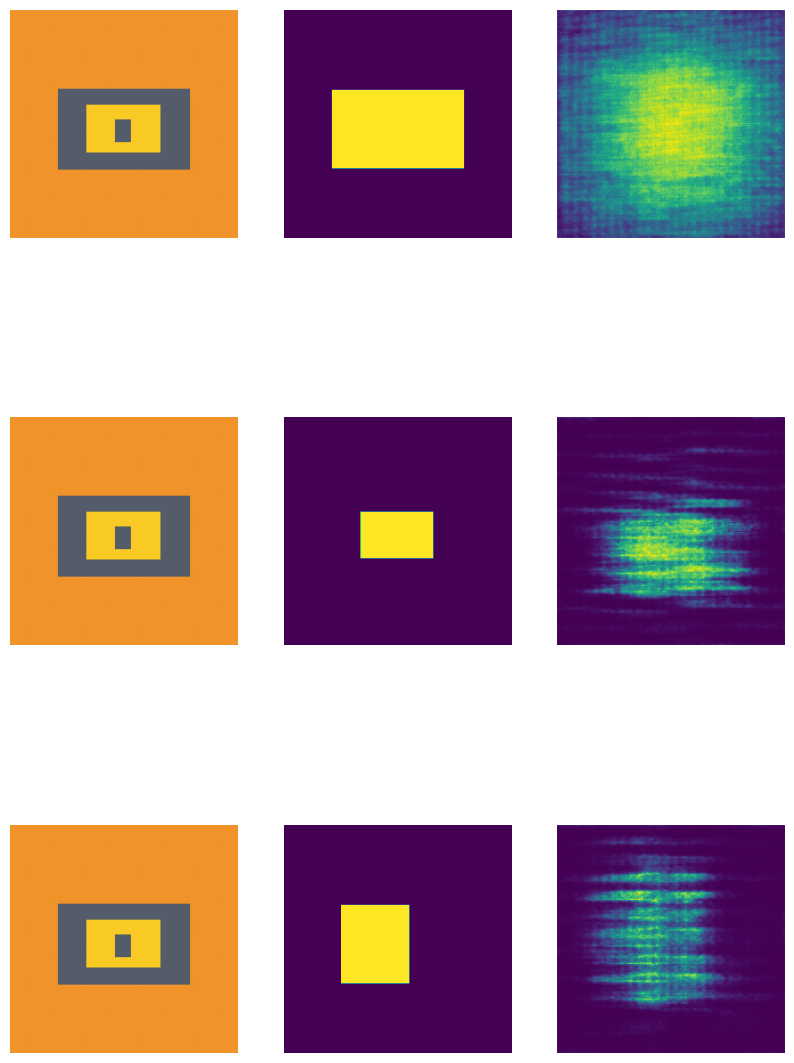

In [41]:
# model.eval()
with torch.inference_mode():
    image, annotation = train_dataset[9]
    attention_mask = annotation[1]
    # attention_mask = output.squeeze().sigmoid().numpy() > 0.2
    annotation_mask = torch.tensor(
                generateAnnotationMask(annotation, attention_mask)
                ).unsqueeze(dim=0).float()
    
    image_cat = torch.cat([image, torch.tensor(attention_mask).unsqueeze(dim=0)], dim=0).to("cuda")
    
    print(image_cat.shape, annotation_mask.shape)
    
    output = model(image_cat.unsqueeze(dim=0))
    
    plt.figure(figsize=(10, 15))
    plt.subplot(3, 3, 1)
    plt.imshow(image.cpu().permute(1,2,0))
    plt.axis("off")
    
    plt.subplot(3, 3, 2)
    plt.imshow(annotation_mask.squeeze())
    plt.axis("off")
    
    plt.subplot(3, 3, 3)
    plt.imshow(output.cpu().squeeze().sigmoid())
    plt.axis("off")
    
    attention_mask = annotation[2][0][1]
    image_cat = torch.cat([image, torch.tensor(attention_mask).unsqueeze(dim=0)], dim=0).to("cuda")
    annotation_mask = torch.tensor(
                generateAnnotationMask(annotation, attention_mask)
                ).unsqueeze(dim=0).float()
    
    print(image_cat.shape, annotation_mask.shape)
    
    output = model(image_cat.unsqueeze(dim=0))
    plt.subplot(3, 3, 4)
    plt.imshow(image.cpu().permute(1,2,0))
    plt.axis("off")
    
    plt.subplot(3, 3, 5)
    plt.imshow(annotation_mask.squeeze())
    plt.axis("off")
    
    plt.subplot(3, 3, 6)
    plt.imshow(output.cpu().squeeze().sigmoid())
    plt.axis("off")
    
    attention_mask = np.zeros((200, 200))
    attention_mask[40: 140, 50: 110] = 1
    attention_mask = attention_mask == 1
    image_cat = torch.cat([image, torch.tensor(attention_mask).unsqueeze(dim=0)], dim=0).to("cuda")
    annotation_mask = torch.tensor(
                generateAnnotationMask(annotation, attention_mask)
                ).unsqueeze(dim=0).float()
    print(image_cat.shape, annotation_mask.shape)
    
    output = model(image_cat.unsqueeze(dim=0))
    plt.subplot(3, 3, 7)
    plt.imshow(image.cpu().permute(1,2,0))
    plt.axis("off")
    
    plt.subplot(3, 3, 8)
    plt.imshow(annotation_mask.squeeze())
    plt.axis("off")
    
    plt.subplot(3, 3, 9)
    plt.imshow(output.squeeze().cpu().sigmoid())
    plt.axis("off")

# Scaling child masks to full scale before segmentation
CNNs aren't scale invariant, try resizing the scale for samller masks before feeding it to network with attention 
mask streched to borders.

## Conclusion

The simple formulation of appending the attention mask to image doesnot work with a segmentation network

Future direction:

- CNN based RNN for one to many generation
- Feature pyramid networks and multiple detection heads? YOLO's objectness score??
